In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

import cqm
import numpy as np
device = torch.device('cuda:0')
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

# Train a test 2D flow

In [11]:
NF_kwargs = {"flow_type":"NSRATQUAD","tail_bound":4,"hidden_features":100,
             "num_layers":5,"num_bins":30,"num_blocks_per_layer":10,"tails":"linear",
            "dropout":0.0,"residual":False}
flow = cqm.make_flow(2,0,NF_kwargs,perm=True).to(device)
x, y = datasets.make_moons(100000, noise=.05)

Training flow


Loss: 0.3547651767730713, p = 9: 100%|██████████| 300/300 [00:56<00:00,  5.30it/s]  


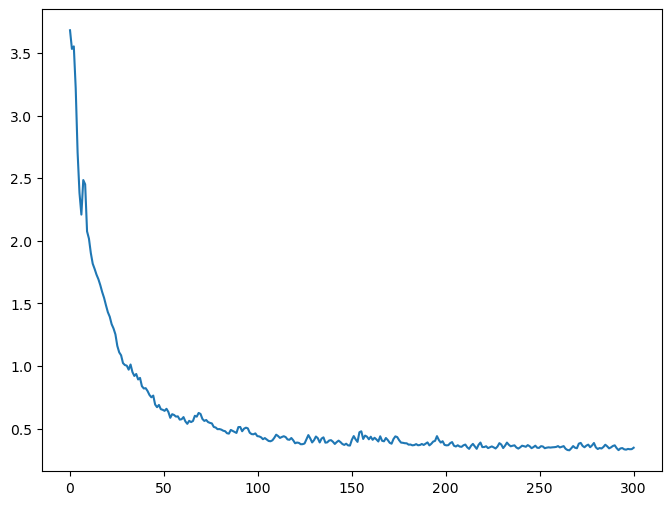

In [12]:
flow = cqm.train_flow(flow,x,n_epoch=30,lr=1e-3,bs=10000,wd=0.0,patience=-1,n_avg=1,anneal=True)

(-1.0, 1.5)

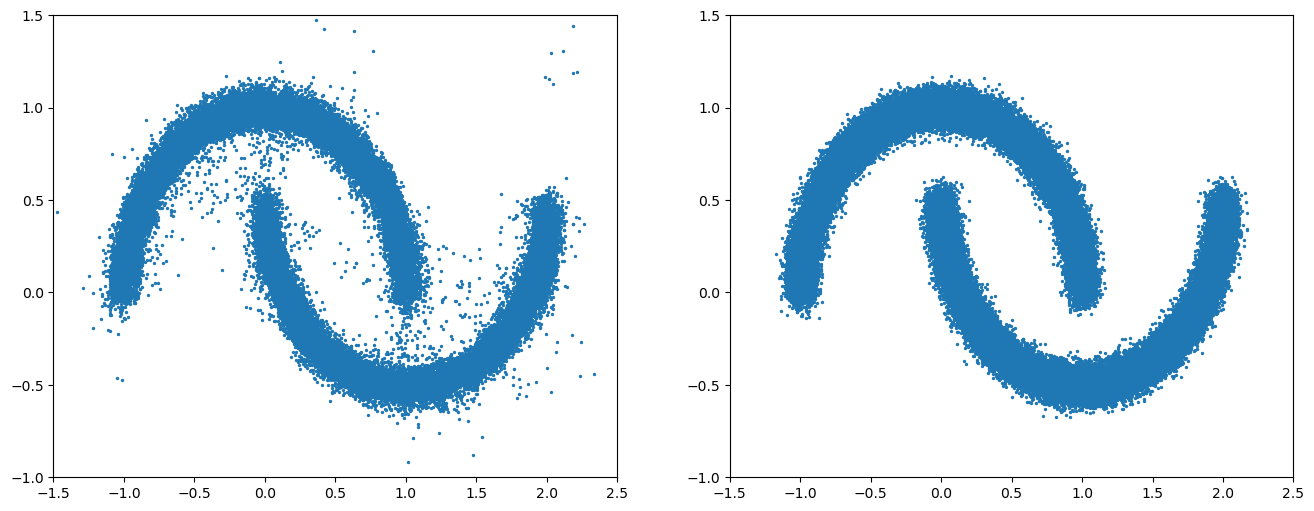

In [13]:
s = []
with torch.no_grad():
    for _ in range(5):
        s.append(flow.sample(10000).numpy())
s = np.concatenate(s)
x, y = datasets.make_moons(100000, noise=.05)
fig,axes = plt.subplots(1,2,figsize=(16,6))
plt.sca(axes[0])
plt.scatter(s[:,0],s[:,1],s=2)
plt.xlim([-1.5,2.5])
plt.ylim([-1,1.5])
plt.sca(axes[1])
plt.scatter(x[:,0],x[:,1],s=2)
plt.xlim([-1.5,2.5])
plt.ylim([-1,1.5])

# Moons, same x distribution

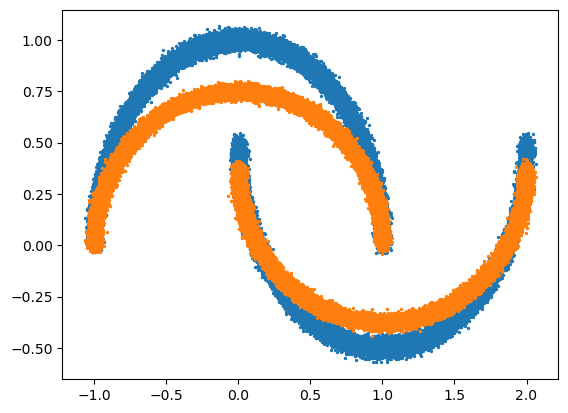

In [5]:
rangeScale = 3

btrain,l1 = datasets.make_moons(100000,noise=0.02)
btest,l2 = datasets.make_moons(100000,noise=0.02)

dtrain,l2 = datasets.make_moons(100000,noise=0.02)
dtest,l2 = datasets.make_moons(100000,noise=0.02)
dtrain[:,1] *= 0.75
dtest[:,1] *= 0.75

plt.scatter(btrain[:,0],btrain[:,1],s=2)
plt.scatter(dtrain[:,0],dtrain[:,1],s=2)

In [7]:
NF_kwargs = {"flow_type":"IRQS","tail_bound":3,"hidden_features":100,
             "num_layers":5,"num_bins":15,"num_blocks_per_layer":5,"tails":"linear"}
rangeScale = 3
trainer = cqm.chainedNFTrainer("moons",btrain,btest,dtrain,dtest,['x','y'],control=[0],NF_kwargs=NF_kwargs,
                                rangeScale=rangeScale,separateScale=False)

RUNNING TRAININGS
Training flow bkgFlow_step0_y


Loss: -0.3147292786836624, p = 107: 100%|██████████| 500/500 [01:38<00:00,  5.10it/s] 


Training flow dataFlow_step0_y


Loss: -0.6041107791662216, p = 89: 100%|██████████| 500/500 [01:38<00:00,  5.08it/s]  


CORRECTING BKG


100%|██████████| 11/11 [00:00<00:00, 14.79it/s]


PLOTTING CORRECTIONS


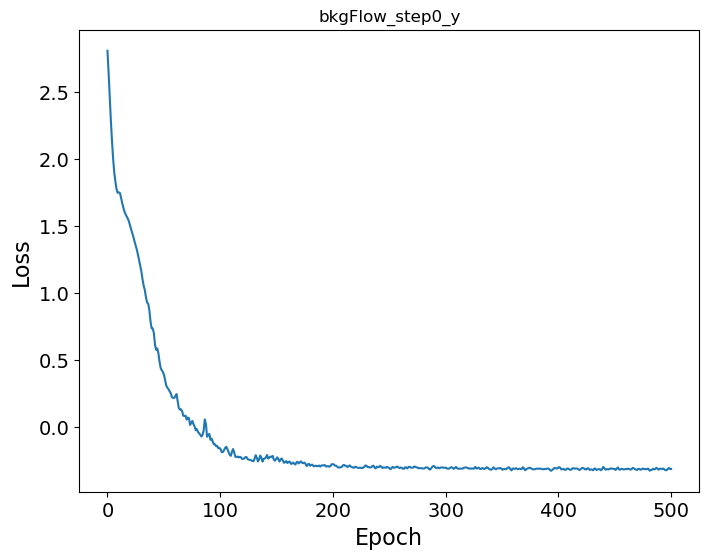

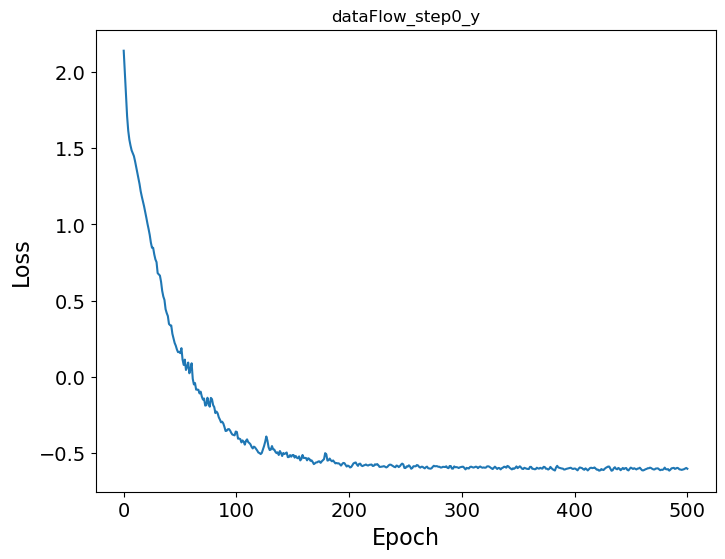

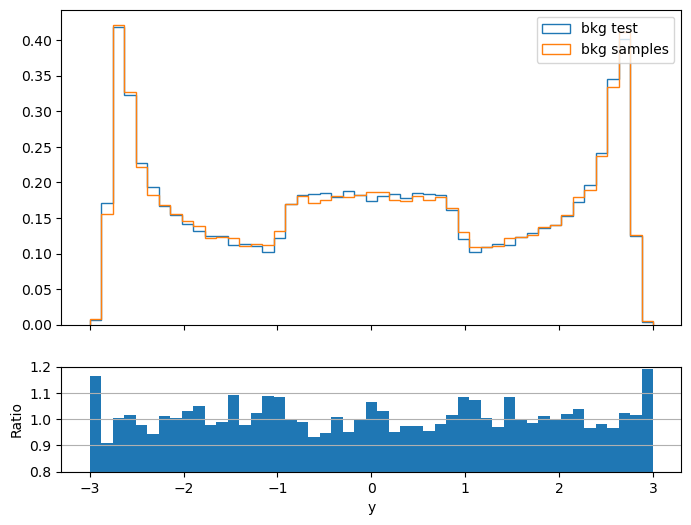

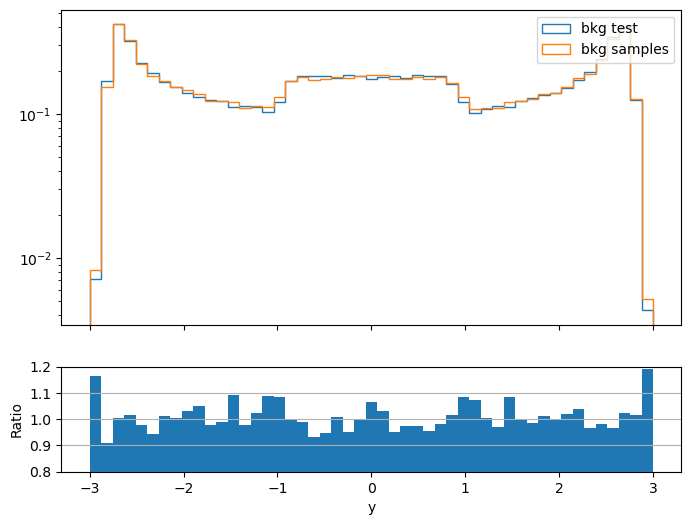

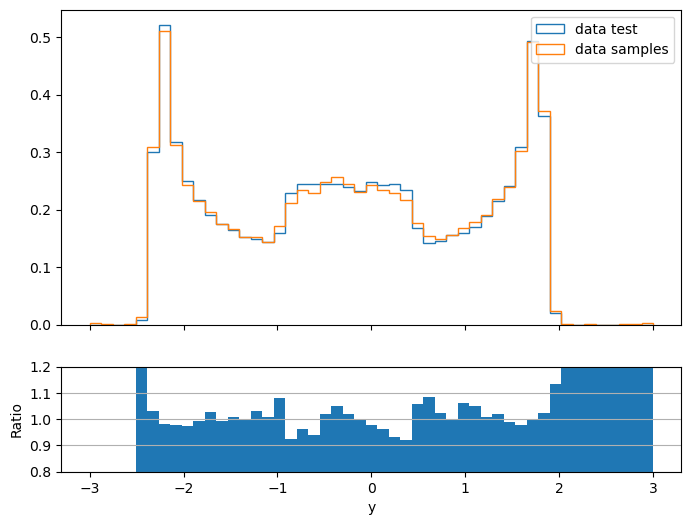

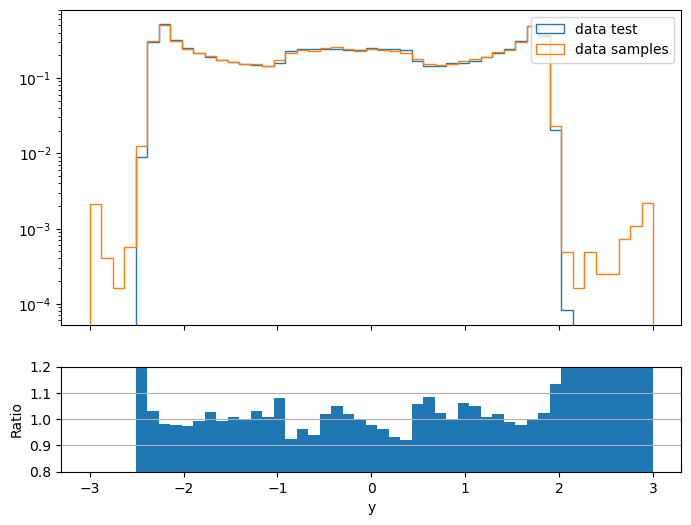

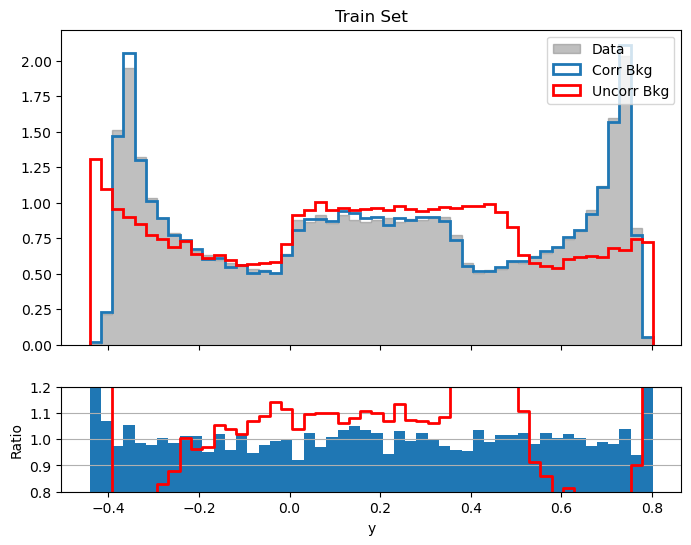

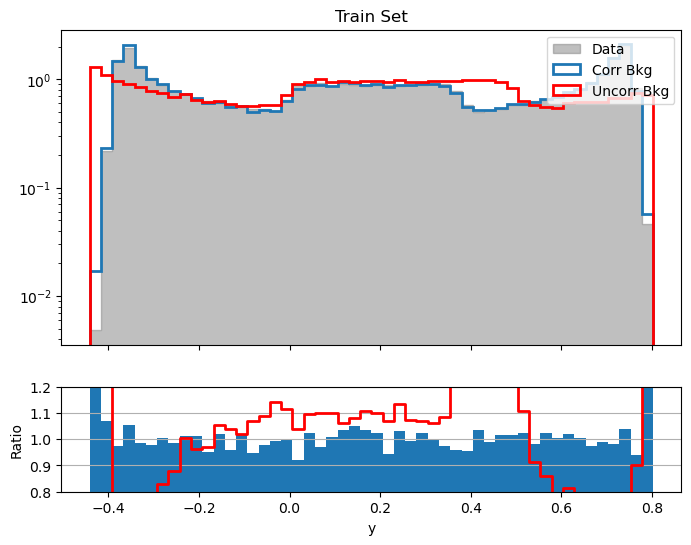

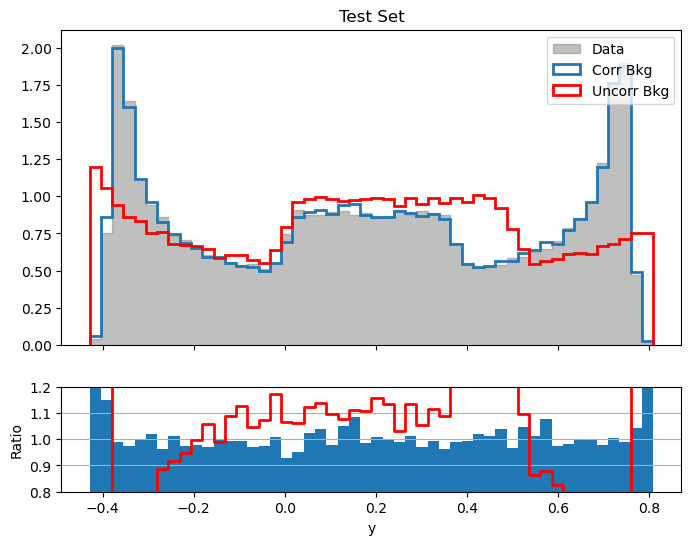

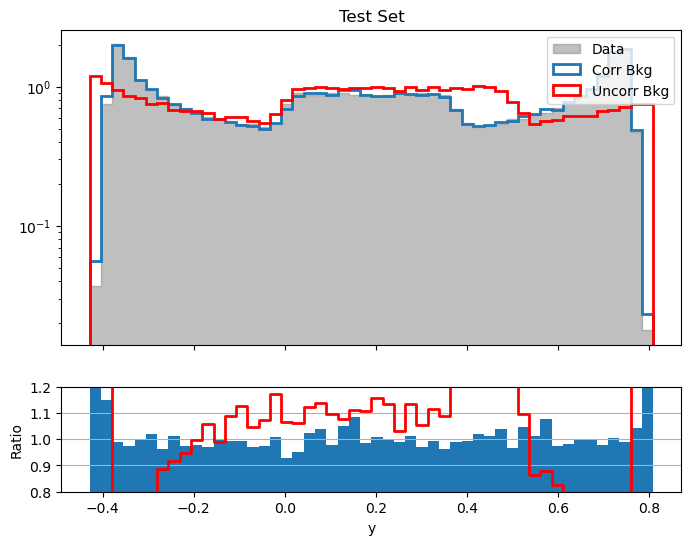

In [8]:
bs = 10000
n_epoch = 50
n_iter = n_epoch*btrain.shape[0]//bs
trainer.runCurrent(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs,anneal=True)

In [9]:
b,l1 = datasets.make_moons(100000,noise=0.02)
d,l2 = datasets.make_moons(100000,noise=0.02)
d[:,1] *= 0.75
bcorr = trainer.correctFull(b)
fitvars = ['x','y']
bcorr = np.concatenate([bcorr[v] for v in fitvars],axis=1)

100%|██████████| 11/11 [00:00<00:00, 30.23it/s]


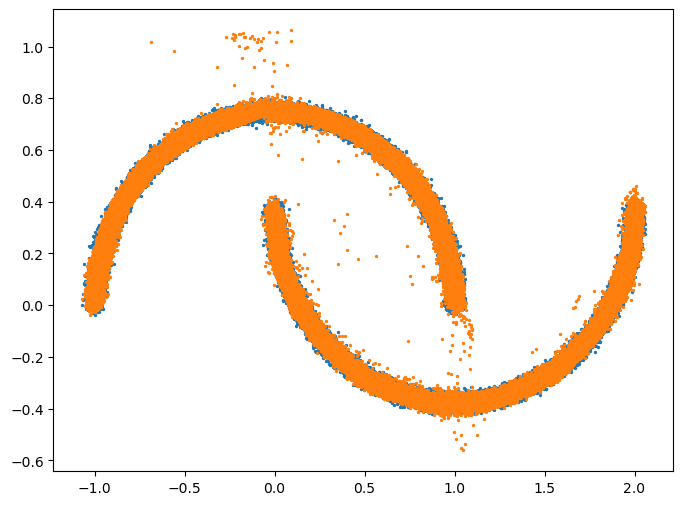

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(d[:,0],d[:,1],s=2)
plt.scatter(bcorr[:,0],bcorr[:,1],s=2)